# Making Big Data Feel Small: Analysis of Hacker News Stories with BigQuery and Ibis 

## Import the libraries we need

in the past if you wanted to use Bigquery, you would need to download and install the google-biquery package, create a service account that would require you to download and access a json file to authorise use, and then find the specific commands to be able to connect to your bigquery project with python. 

Ibis makes this process significantly less daunting by giving you all the tools you need to access your account with the code shown below. Not only that but it lets you analyse your data just like you would with pandas without needing to learn the bigquery specific dialect of sql. 

(do a side by side comparison of the code (https://towardsdatascience.com/run-bigquery-sql-using-python-api-client-b5287ac05b99)

show that you can use your own data in BQ not just the BigQuery datasets (sales example)

In this article we'll be looking at how to analyse millions of rows of data in seconds using Ibis and the bigquery backend. let's start by getting connected to our bigquery database to access Hacker News data. 

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import spacy
nlp = spacy.load("en_core_web_sm")

import ibis
ibis.options.interactive = True

## Connect to BigQuery

In Ibis this only requires the commands below. We first connect to the database and then we connect to the specific table we want to query! In the past you would need to write out an SQL statement maybe something that looks 

In [24]:
hnconn = ibis.bigquery.connect(
    project_id='solar-safeguard-366612',
    dataset_id='bigquery-public-data.hacker_news'
)

In [25]:
full = hnconn.table('full', database='bigquery-public-data.hacker_news')

## Query the Table 

Next we'll query the table just like we would a pandas dataframe, to get a better understanding of the data we have. 

In [26]:
full.head()

/Users/marlenemhangami/miniconda3/envs/dask-tutorial/lib/python3.9/site-packages/ibis/backends/pandas/client.py:255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  return column.astype(out_dtype.to_pandas(), errors='ignore')
/Users/marlenemhangami/miniconda3/envs/dask-tutorial/lib/python3.9/site-packages/ibis/backends/pandas/client.py:255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  return column.astype(out_dtype.to_pandas(), errors='ignore')


,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,I hate them. They take out all the benefits of...,<NA>,gigatexal,<NA>,1556904415,2019-05-03 17:26:55,comment,19820344,19818421,<NA>,<NA>,<NA>
1,None,None,It&#x27;s so easy to monkey-patch a set of tra...,<NA>,TomK32,<NA>,1556904439,2019-05-03 17:27:19,comment,19820347,19819548,<NA>,<NA>,<NA>
2,None,None,"&gt; Accounting 101, capital items do not coun...",<NA>,mbesto,<NA>,1556904424,2019-05-03 17:27:04,comment,19820346,19817738,<NA>,<NA>,<NA>
3,None,None,Both of these things can be true: that the top...,<NA>,ahupp,<NA>,1556904400,2019-05-03 17:26:40,comment,19820341,19820081,<NA>,<NA>,<NA>
4,None,None,Database algorithms are typically designed for...,<NA>,jandrewrogers,<NA>,1556904398,2019-05-03 17:26:38,comment,19820340,19819554,<NA>,<NA>,<NA>


In [27]:
full.type.value_counts()

,type,count
0,pollopt,13792
1,job,15797
2,poll,2004
3,comment,28629372
4,story,4667125


In [112]:
full.count()

33328090

We can see that we're working with 33 Million rows of data! Using Ibis this shouldn't feel any different from working with Pandas on a smaller dataset though, it's also just as fast! 

## Clean the Data

Next we'll clean our data, by simply removing all of the comments that don't have text in them and all the stories that don't contain text or a title.

In [28]:
full_comments = full.filter(full.type == 'comment')
print(full_comments.count())
clean_comments = full_comments[full_comments['text'].notnull() | full_comments['title'].notnull()]
print(clean_comments.count())

28629372
27795400


In [29]:
full_stories = full.filter(full.type == 'story')
print(full_stories.count()) 
clean_stories= full_stories[full_stories['title'].notnull()]
print(clean_stories.count())

4667125
4386315


## Join the Comments and Story Data 

After removing the comments and stories that are not relevant we want to join the comments and story table so we can better analyse what the comments mean about the story. We'll carry out some sentiment analysis to figure out which kinds of articles get positive comments and which ones don't. 

In [30]:
stories_and_comments = clean_stories.inner_join(clean_comments, predicates=clean_stories['id'] == clean_comments['parent'])

In [31]:
stry_cmnts = stories_and_comments[['title_x', 'text_x', 'by_x', 'score_x', 'timestamp_x','type_x','ranking_x','id_x','parent_y','text_y','by_y', 'timestamp_y', 'id_y']]
stry_cmnts.sort_by('id_x')

/Users/marlenemhangami/miniconda3/envs/dask-tutorial/lib/python3.9/site-packages/ibis/backends/pandas/client.py:255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  return column.astype(out_dtype.to_pandas(), errors='ignore')
/Users/marlenemhangami/miniconda3/envs/dask-tutorial/lib/python3.9/site-packages/ibis/backends/pandas/client.py:255: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  return column.astype(out_dtype.to_pandas(), errors='ignore')


,title_x,text_x,by_x,score_x,timestamp_x,type_x,ranking_x,id_x,parent_y,text_y,by_y,timestamp_y,id_y
0,Y Combinator,None,pg,57,2006-10-09 18:21:51,story,<NA>,1,1,&#34;the rising star of venture capital&#34; -...,sama,2006-10-09 19:51:01,15
1,Y Combinator,None,pg,57,2006-10-09 18:21:51,story,<NA>,1,1,I'm nX 1 too<p>;)\n,vice,2007-11-22 12:50:54,82729
2,Y Combinator,None,pg,57,2006-10-09 18:21:51,story,<NA>,1,1,"So, just to see how hard it is to make the lon...",jacquesm,2009-02-19 12:21:23,487171
3,Y Combinator,None,pg,57,2006-10-09 18:21:51,story,<NA>,1,1,sequential numbering\n I must be bored,kleevr,2008-07-02 20:29:48,234509
4,Salaries at VC-backed companies,None,pg,8,2006-10-09 20:00:38,story,<NA>,20,20,"This is interesting, but the limitations becom...",starklysnarky,2006-10-10 02:30:53,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Sam Odio: Real Person or Anybots (robot) proto...,None,dpapathanasiou,10,2007-05-17 02:30:44,story,<NA>,22661,22661,<i>You know you've been on news.yc too long wh...,staunch,2007-05-17 11:04:52,22752
9996,Sam Odio: Real Person or Anybots (robot) proto...,None,dpapathanasiou,10,2007-05-17 02:30:44,story,<NA>,22661,22661,"Alas, Sam is real. He mooched off my couch fo...",RyanGWU82,2007-05-17 06:19:54,22701
9997,Sam Odio: Real Person or Anybots (robot) proto...,None,dpapathanasiou,10,2007-05-17 02:30:44,story,<NA>,22661,22661,Sam is the best submitter of front page TechCr...,vlad,2007-05-17 10:11:40,22736
9998,Sam Odio: Real Person or Anybots (robot) proto...,None,dpapathanasiou,10,2007-05-17 02:30:44,story,<NA>,22661,22661,I can confirm that Sam is indeed mostly metal....,maxklein,2007-05-17 08:39:13,22725


## Analysing the data

Next lets have a closer look at some things the data tells us. 
We'll start by finding out what score a story has to have to be considered good, average and not so good. 

In [117]:
min_score = stry_cmnts.score_x.min()
min_score

-1

In [118]:
max_score = stry_cmnts.score_x.max()
max_score

6015

In [119]:
avg_score= stry_cmnts.score_x.mean()
avg_score

185.47600946186523

This data suggests that stories with scores over 6000 can be considered viral or op stories on HN 

## What Are People Writing About on HN? 

In [32]:
titles = stry_cmnts[['title_x', 'score_x']]
sorted_titles = titles.sort_by(ibis.desc('score_x'))
sorted_titles

,title_x,score_x
0,Stephen Hawking has died,6015
1,Stephen Hawking has died,6015
2,Stephen Hawking has died,6015
3,Stephen Hawking has died,6015
4,Stephen Hawking has died,6015
...,...,...
9995,Ask HN: Is S3 down?,2589
9996,Ask HN: Is S3 down?,2589
9997,Ask HN: Is S3 down?,2589
9998,Ask HN: Is S3 down?,2589


In [97]:
def find_entity(title):
    parsed_title = nlp(title)
    entity_arr = []
    for num, entity in enumerate(parsed_title.ents):
        entity_arr.append(entity.text)
    return  ' '.join(entity_arr)



In [101]:
new_table = sorted_titles["title_x"].execute()
new_table
# sorted_titles["entity"]= sorted_titles["title_x"]

0           Stephen Hawking has died
1           Stephen Hawking has died
2           Stephen Hawking has died
3           Stephen Hawking has died
4           Stephen Hawking has died
                    ...             
9995             Ask HN: Is S3 down?
9996    GitHub is now free for teams
9997             Ask HN: Is S3 down?
9998    GitHub is now free for teams
9999    GitHub is now free for teams
Name: title_x, Length: 10000, dtype: object

In [103]:
entity_col = new_table.apply(find_entity)

In [131]:

top_entities = entity_col.value_counts()
top_entities = top_entities[1:]

Text(0, 0.5, 'counts')

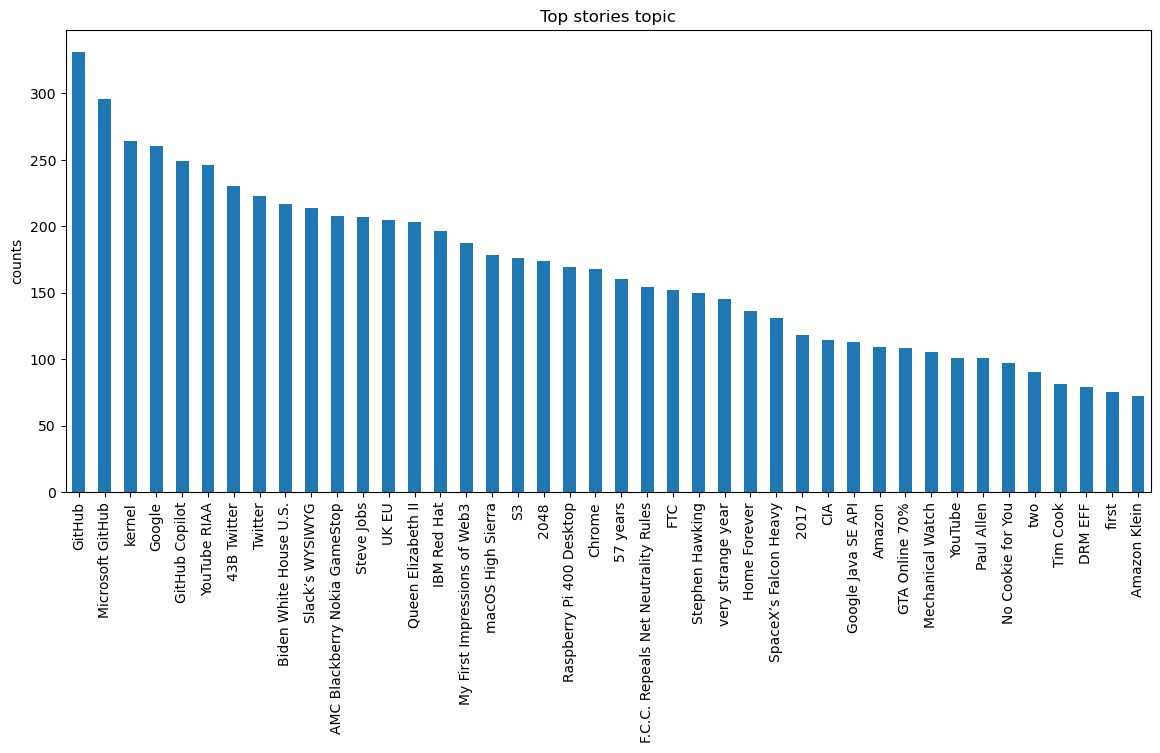

In [132]:
top_entities.plot(x="entity",y=["counts"],
                     kind="bar",figsize=(14,6),
                     title='Top stories topic').set_ylabel("counts")

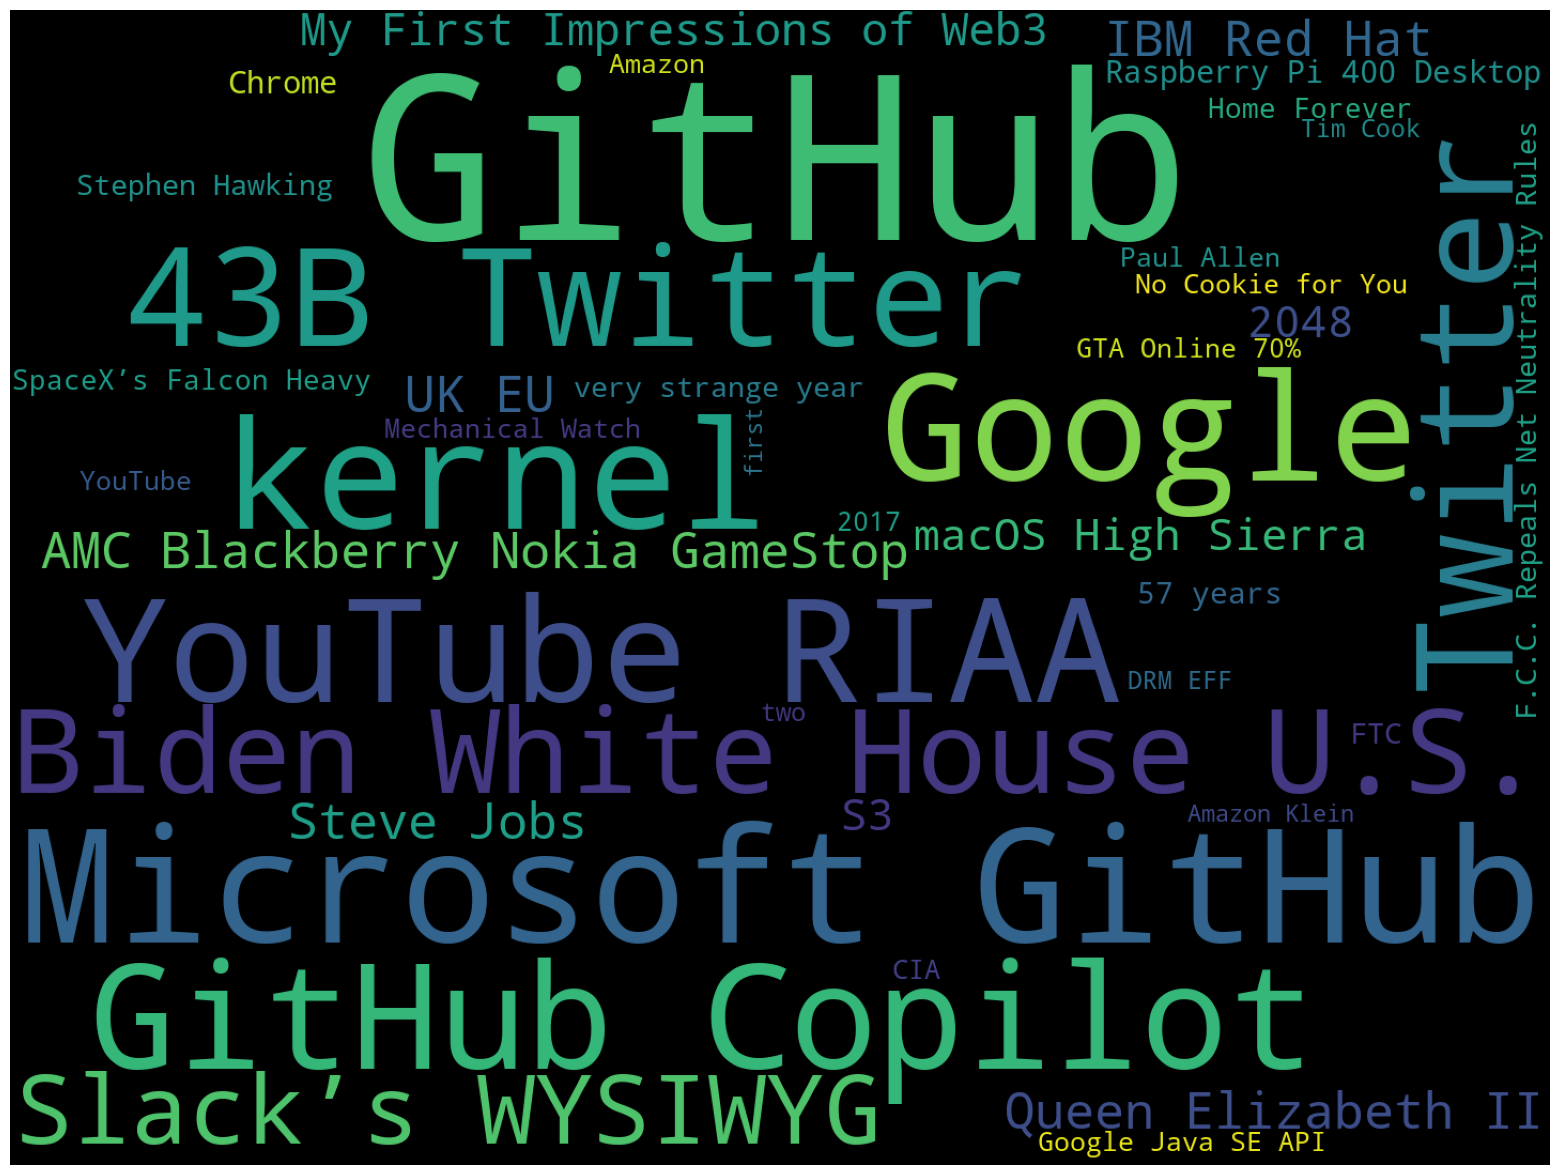

In [141]:
cloud = WordCloud(width=1440, height= 1080,max_words= 200).generate_from_frequencies(top_entities)
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off');
plt.show()

The word that seems to be mentioned the most is Github, followed closely by Microsoft Github! This seems to corroborate the recent announcement from Microsoft that the service has over 90 million active users on it, up from 28 million when it was aquired in 2018. Microsoft says the code repository service now has an annual recurring revenue of $1 billion, also up from the $200-$300 million it was generating at the time of the aquisition.  (https://techcrunch.com/2022/10/25/microsoft-says-github-now-has-a-1b-arr-90m-active-users/)